<a href="https://colab.research.google.com/github/RafCMagus/1.2.1_1Pandas/blob/main/DetectorEmociones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo de titulación  
## Tema: Creación de un sistema de reconocimiento de emociones básicas usando técnicas de visión artificial.
## Autor: Rafael Guillermo Castro Merino

## Instalacion de las librerias necesarias para manipular imagenes y redes neuronales

In [ ]:
# Instalación de librerías necesarias
!pip install tensorflow keras mtcnn opencv-python-headless matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.5 MB/s eta 0:00:00


# Cargar librerias, preprocesa imagenes y realizar MTCNN

In [ ]:
import os
import cv2
import shutil
import numpy as np
from PIL import Image
from mtcnn import MTCNN
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Etiquetas de emociones para cada conjunto de datos

In [ ]:
emotion_labels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}


## Procesamiento de imagenes del conjunto de datos FER2013 y uso de MTCNN

In [ ]:
# Leer el dataset FER2013
csv_path = '/content/drive/MyDrive/dataset3/fer2013.csv'
data = pd.read_csv(csv_path)
output_dir = '/content/fer2013_images'
os.makedirs(output_dir, exist_ok=True)

original_counts = {label: 0 for label in emotion_labels.values()}

for idx, row in data.iterrows():
    emotion_code = row['emotion']
    emotion = emotion_labels[emotion_code]
    pixels = np.array(row['pixels'].split(), dtype='uint8').reshape(48, 48)

    image_path = os.path.join(output_dir, f"{idx}_{emotion}.png")
    cv2.imwrite(image_path, pixels)
    original_counts[emotion] += 1

print("Imágenes originales guardadas correctamente.")

Imágenes originales guardadas correctamente.


In [ ]:
# Procesado de imagenes

def upscale_image(image, scale_factor=2):
    """
    Aumenta la resolución de la imagen usando interpolación bicúbica.
    """
    return cv2.resize(image, (image.shape[1] * scale_factor, image.shape[0] * scale_factor), interpolation=cv2.INTER_CUBIC)

def reduce_noise_light(image):
    """
    Aplica un filtro de suavizado menos agresivo para conservar detalles.
    """
    return cv2.fastNlMeansDenoising(image, None, h=5, templateWindowSize=7, searchWindowSize=21)

def apply_clahe(image, clip_limit=2.0, grid_size=(8, 8)):
    """
    Aplica CLAHE para mejorar el contraste sin perder detalles finos.
    """
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    return clahe.apply(image)

def align_face(image, keypoints):
    """
    Alinea la cara utilizando los puntos de los ojos detectados por MTCNN.
    """
    left_eye = keypoints['left_eye']
    right_eye = keypoints['right_eye']

    delta_x = right_eye[0] - left_eye[0]
    delta_y = right_eye[1] - left_eye[1]
    angle = np.arctan2(delta_y, delta_x) * 180.0 / np.pi

    eyes_center = (float((left_eye[0] + right_eye[0]) / 2), float((left_eye[1] + right_eye[1]) / 2))
    M = cv2.getRotationMatrix2D(eyes_center, angle, 1.0)
    aligned_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_CUBIC)

    return aligned_image

aligned_faces_dir = '/content/fer2013_aligned_faces'
os.makedirs(aligned_faces_dir, exist_ok=True)

In [ ]:
detector = MTCNN()
aligned_counts = {label: 0 for label in emotion_labels.values()}


In [ ]:
# Comparación visual de imágenes
def plot_comparison(original, processed, title):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title("Original")
    axes[1].imshow(processed, cmap='gray')
    axes[1].set_title(title)
    plt.show()

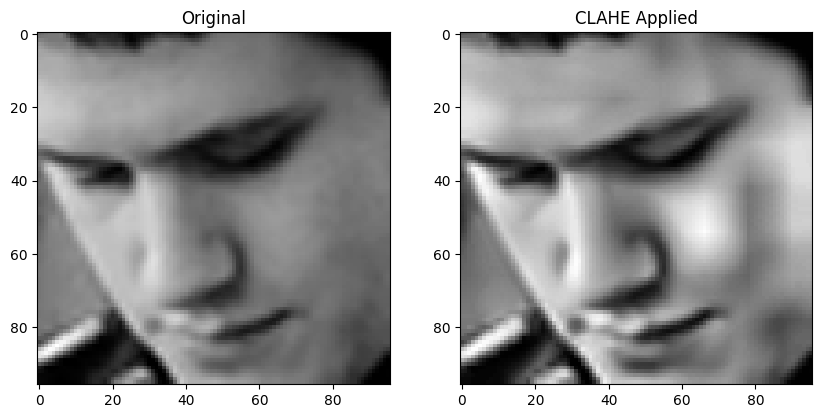

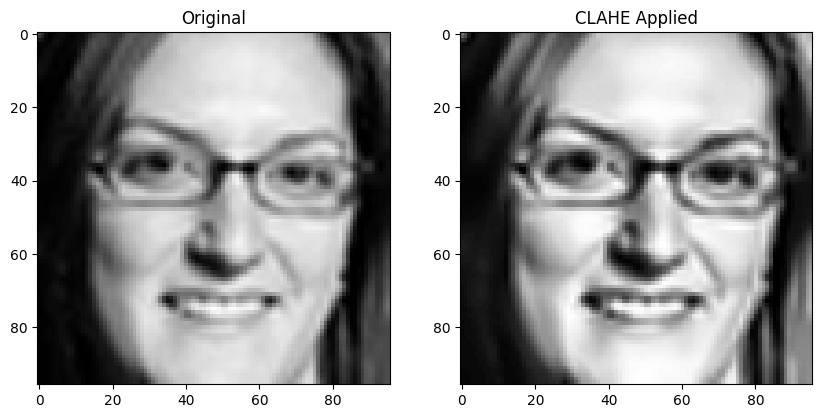

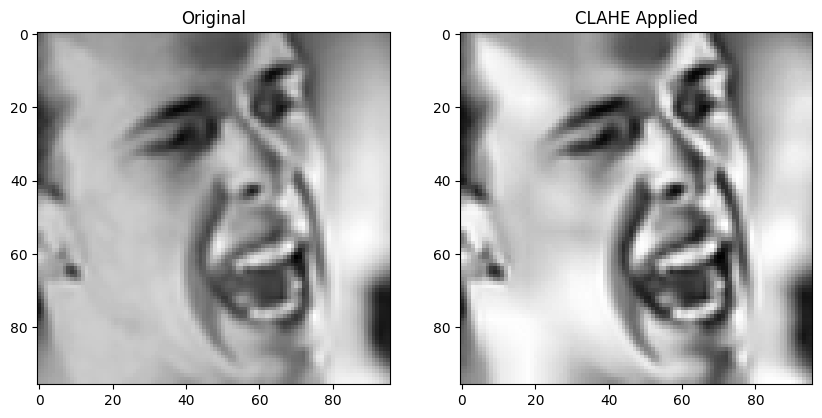

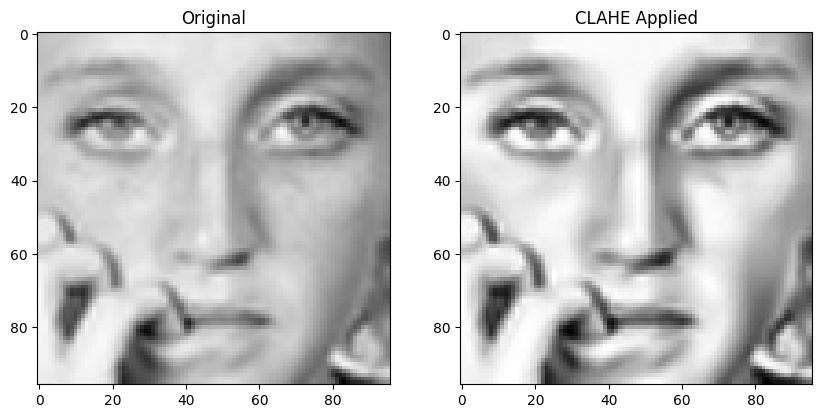

Caras alineadas guardadas correctamente.


In [ ]:
counter = 0
for file in os.listdir(output_dir):
    image_path = os.path.join(output_dir, file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Preprocesamiento
    upscaled = upscale_image(image, scale_factor=2)
    denoised = reduce_noise_light(upscaled)
    clahe_image = apply_clahe(denoised, clip_limit=2.0, grid_size=(8, 8))

    # Comparar imágenes
    if counter <= 5:
      plot_comparison(upscaled, clahe_image, "CLAHE Applied")
    counter +=1

    # Detectar rostros
    image_rgb = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2RGB)
    results = detector.detect_faces(image_rgb)
    emotion = file.split('_')[1].split('.')[0]

    for i, result in enumerate(results):
        x, y, w, h = result['box']
        keypoints = result['keypoints']

        face = image_rgb[y:y+h, x:x+w]
        aligned_face = align_face(face, keypoints)
        face_resized = cv2.resize(aligned_face, (224, 224))

        face_path = os.path.join(aligned_faces_dir, f"{file.split('.')[0]}_aligned_{i}_{emotion}.png")
        Image.fromarray(face_resized).save(face_path)

        aligned_counts[emotion] += 1

print("Caras alineadas guardadas correctamente.")

In [ ]:
print("Análisis final de imágenes:")
for emotion, count in original_counts.items():
    aligned = aligned_counts.get(emotion, 0)
    print(f"{emotion}: Originales = {count}, Alineadas = {aligned}")

Análisis final de imágenes:
Angry: Originales = 4953, Alineadas = 3883
Disgust: Originales = 547, Alineadas = 398
Fear: Originales = 5121, Alineadas = 3884
Happy: Originales = 8989, Alineadas = 7540
Sad: Originales = 6077, Alineadas = 4419
Surprise: Originales = 4002, Alineadas = 3294
Neutral: Originales = 6198, Alineadas = 5339


## Procesamiento de Dataset de JAFFE


In [ ]:
# Etiquetas de emociones para el conjunto de datos

import os
import shutil

# Definir las emociones según los prefijos en el nombre de archivo
emotion_map = {
    "AN": "Angry",
    "DI": "Disgust",
    "FE": "Fear",
    "HA": "Happy",
    "SA": "Sad",
    "SU": "Surprise",
    "NE": "Neutral"
}

In [ ]:
# Ruta de las imágenes del dataset JAFFE
input_dir = "/content/drive/MyDrive/dataset3/jaffe"  # Cambiar a la ruta donde están las imágenes
output_dir = "/content/jaffe_ordenado"  # Directorio de salida


In [ ]:
# Crear carpetas para cada emoción
for emotion in emotion_map.values():
    os.makedirs(os.path.join(output_dir, emotion), exist_ok=True)

In [ ]:
# Procesar cada imagen
for file in os.listdir(input_dir):
    if file.endswith(".tiff"):  # Solo procesar archivos TIFF
        try:
            # Buscar la palabra clave correspondiente a la emoción en el nombre del archivo
            emotion = None
            for code, emotion_name in emotion_map.items():
                if code in file:  # Verificar si el código de emoción está en el nombre del archivo
                    emotion = emotion_name
                    break

            if emotion:
                # Ruta de origen y destino
                src_path = os.path.join(input_dir, file)
                dest_path = os.path.join(output_dir, emotion, file)

                # Mover la imagen a la carpeta correspondiente
                shutil.move(src_path, dest_path)
                print(f"Movido: {file} -> {emotion}")
            else:
                print(f"No se encontró una emoción válida en el archivo: {file}")
        except Exception as e:
            print(f"Error procesando el archivo {file}: {e}")

print("Proceso completado. Las imágenes han sido ordenadas por emociones.")




Movido: KM.AN2.18.tiff -> Angry
Movido: KL.SA1.161.tiff -> Sad
Movido: KL.SU2.165.tiff -> Surprise
Movido: KA.AN1.39.tiff -> Angry
Movido: KL.SU1.164.tiff -> Surprise
Movido: KL.SU3.166.tiff -> Surprise
Movido: KL.NE3.157.tiff -> Neutral
Movido: KL.SA2.162.tiff -> Sad
Movido: KL.SA3.163.tiff -> Sad
Movido: KM.AN1.17.tiff -> Angry
Movido: KM.SU3.16.tiff -> Surprise
Movido: KM.SU2.15.tiff -> Surprise
Movido: KM.SA3.11.tiff -> Sad
Movido: KM.SU1.14.tiff -> Surprise
Movido: KM.SA2.10.tiff -> Sad
Movido: KM.NE2.2.tiff -> Neutral
Movido: KM.HA4.7.tiff -> Happy
Movido: KM.SA5.13.tiff -> Sad
Movido: KM.SA1.9.tiff -> Sad
Movido: KM.NE3.3.tiff -> Neutral
Movido: KM.NE1.1.tiff -> Neutral
Movido: KM.HA3.6.tiff -> Happy
Movido: KM.HA1.4.tiff -> Happy
Movido: KM.DI3.22.tiff -> Disgust
Movido: KM.DI1.20.tiff -> Disgust
Movido: KM.FE2.24.tiff -> Fear
Movido: KM.FE1.23.tiff -> Fear
Movido: KM.FE3.25.tiff -> Fear
Movido: KM.AN3.19.tiff -> Angry
Movido: KM.HA2.5.tiff -> Happy
Movido: KA.FE1.45.tiff -> Fe

Mostrando imágenes para emoción: Angry


Mostrando imágenes para emoción: Happy


Mostrando imágenes para emoción: Neutral


Mostrando imágenes para emoción: Surprise


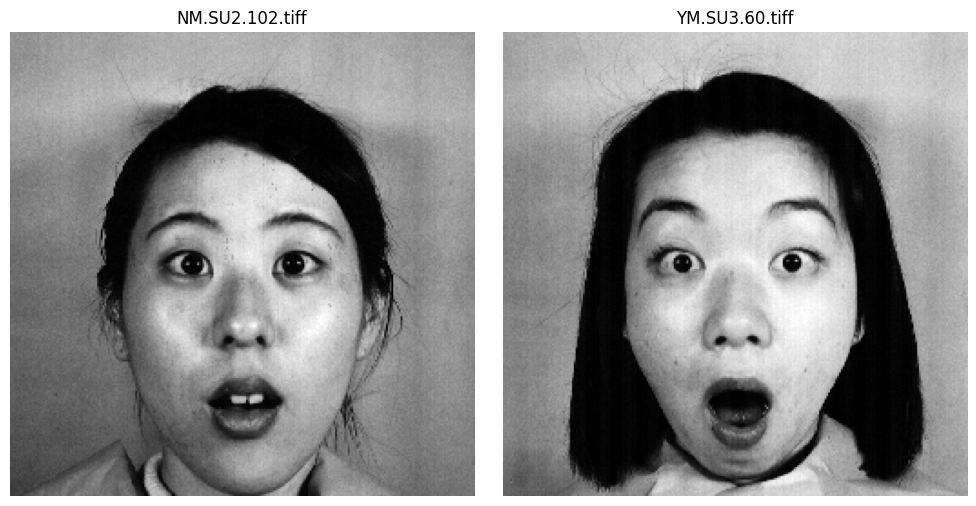

Mostrando imágenes para emoción: Disgust


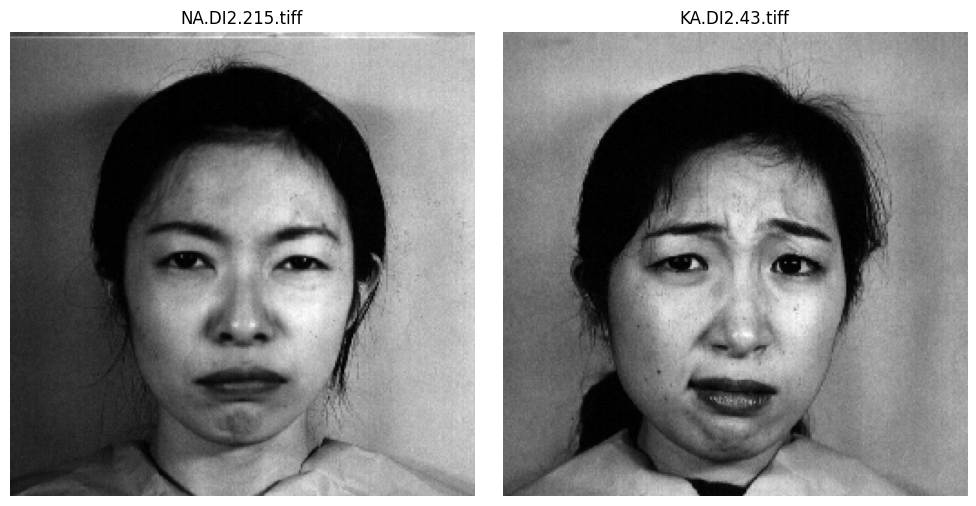

Mostrando imágenes para emoción: Sad


Mostrando imágenes para emoción: Fear


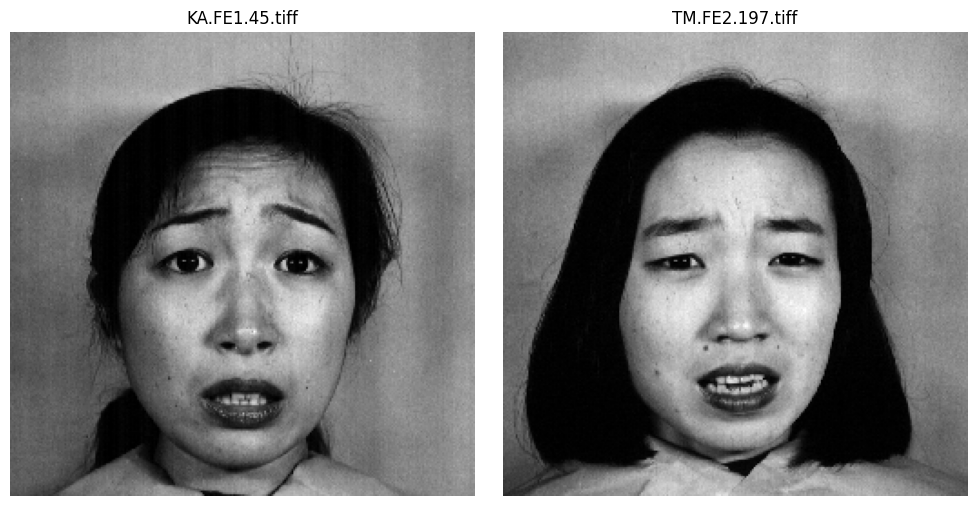

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

output_dir = "/content/jaffe_ordenado"  # Directorio de salida

# Mostrar dos imágenes por cada carpeta
def display_images(output_dir):
    found_images = False  # Bandera para verificar si se encuentran imágenes
    for emotion in os.listdir(output_dir):
        emotion_dir = os.path.join(output_dir, emotion)
        if os.path.isdir(emotion_dir):  # Verificar si es una carpeta
            images = [file for file in os.listdir(emotion_dir) if file.lower().endswith(".tiff")]
            if len(images) > 0:
                found_images = True
                print(f"Mostrando imágenes para emoción: {emotion}")

                # Configuración para Google Colab
                fig, axes = plt.subplots(1, min(2, len(images)), figsize=(10, 5))

                if len(images) == 1:  # Si hay solo una imagen, ajusta la visualización
                    axes = [axes]

                for i, ax in enumerate(axes):
                    img_path = os.path.join(emotion_dir, images[i])
                    img = Image.open(img_path)
                    ax.imshow(img, cmap='gray')
                    ax.axis('off')
                    ax.set_title(images[i])

                plt.tight_layout()  # Ajustar el diseño
                plt.show()
            else:
                print(f"La carpeta '{emotion}' no contiene imágenes TIFF.")

    if not found_images:
        print("No se encontraron imágenes en el directorio especificado.")

# Llamar a la función después del procesamiento
display_images(output_dir)



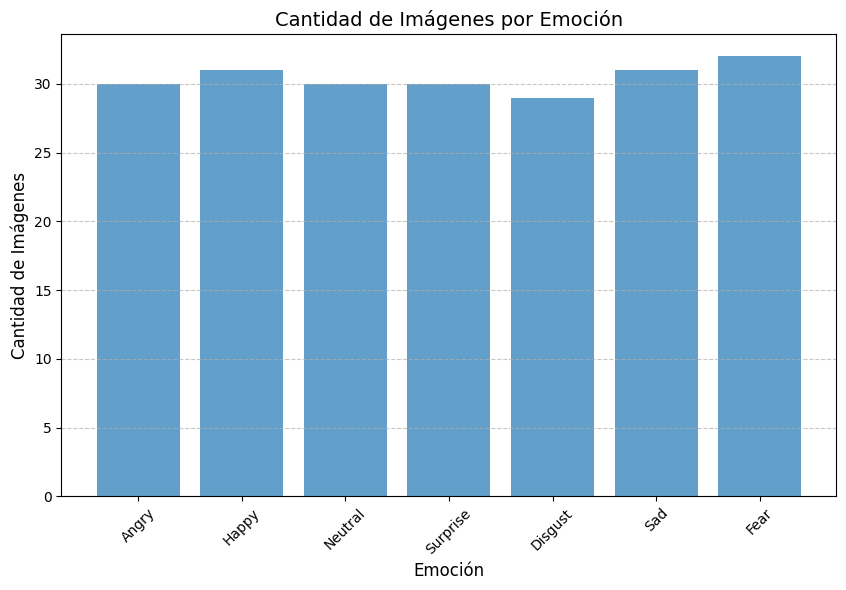

In [ ]:
# Reimportar las bibliotecas necesarias después del reinicio del estado
import os
import matplotlib.pyplot as plt

# Redefinir el directorio de salida
output_dir = "/content/jaffe_ordenado"  # Cambiar según tu entorno si es necesario

# Función para contar imágenes por emoción
def count_images_per_emotion(output_dir):
    emotion_counts = {}  # Diccionario para almacenar los conteos
    for emotion in os.listdir(output_dir):
        emotion_dir = os.path.join(output_dir, emotion)
        if os.path.isdir(emotion_dir):  # Verificar si es una carpeta
            # Contar imágenes TIFF en la carpeta
            images = [file for file in os.listdir(emotion_dir) if file.lower().endswith(".tiff")]
            emotion_counts[emotion] = len(images)
    return emotion_counts

# Obtener el conteo
image_counts = count_images_per_emotion(output_dir)

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(image_counts.keys(), image_counts.values(), alpha=0.7)
plt.title("Cantidad de Imágenes por Emoción", fontsize=14)
plt.xlabel("Emoción", fontsize=12)
plt.ylabel("Cantidad de Imágenes", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
import os

# Definir el directorio de salida
output_dir = "/content/jaffe_ordenado"  # Cambiar si la carpeta tiene otra ubicación

# Función para contar imágenes por emoción
def count_images_per_emotion(output_dir):
    if not os.path.exists(output_dir):
        print(f"El directorio {output_dir} no existe. Verifica la ruta.")
        return []

    emotion_counts = []  # Lista para almacenar las emociones y conteos
    for emotion in os.listdir(output_dir):
        emotion_dir = os.path.join(output_dir, emotion)
        if os.path.isdir(emotion_dir):  # Verificar si es una carpeta
            # Contar imágenes TIFF en la carpeta
            images = [file for file in os.listdir(emotion_dir) if file.lower().endswith(".tiff")]
            emotion_counts.append({"Emoción": emotion, "Cantidad de Imágenes": len(images)})
    return emotion_counts

# Llamar a la función
image_counts = count_images_per_emotion(output_dir)

# Mostrar los resultados como texto
if image_counts:
    for count in image_counts:
        print(f"Emoción: {count['Emoción']}, Cantidad de Imágenes: {count['Cantidad de Imágenes']}")
else:
    print("No se encontraron datos. Verifica el directorio.")


Emoción: Angry, Cantidad de Imágenes: 30
Emoción: Happy, Cantidad de Imágenes: 31
Emoción: Neutral, Cantidad de Imágenes: 30
Emoción: Surprise, Cantidad de Imágenes: 30
Emoción: Disgust, Cantidad de Imágenes: 29
Emoción: Sad, Cantidad de Imágenes: 31
Emoción: Fear, Cantidad de Imágenes: 32


# Enfoque multicanal para mejorar precision del modelo


In [ ]:
import os
import zipfile
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19, ResNet50, MobileNetV2
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report



In [ ]:
# Función para descomprimir un archivo ZIP
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Archivo descomprimido en: {extract_to}")


In [ ]:
# Función para cargar imágenes desde carpetas organizadas
def load_images_from_directory(directory, target_size):
    images = []
    labels = []
    label_map = {label: idx for idx, label in enumerate(sorted(os.listdir(directory)))}
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_file)
                try:
                    img = load_img(image_path, target_size=target_size)
                    img_array = img_to_array(img) / 255.0  # Normalización
                    images.append(img_array)
                    labels.append(label_map[label])
                except Exception as e:
                    print(f"Error cargando la imagen {image_path}: {e}")
    return np.array(images), np.array(labels)

In [ ]:
# Función para extraer características de un modelo
def extract_features_from_model(model, images):
    features = []
    for img in images:
        feature = model.predict(np.expand_dims(img, axis=0))
        features.append(feature.flatten())
    return np.array(features)

In [ ]:
# Descomprimir archivos ZIP
fer_zip = "/content/drive/MyDrive/dataset3/fer2013_ordered.zip"
jaffe_zip = "/content/drive/MyDrive/dataset3/jaffe_ordenado.zip"

fer_directory = "/content/fer2013_ordered"
jaffe_directory = "/content/jaffe_ordenado"

unzip_file(fer_zip, fer_directory)
unzip_file(jaffe_zip, jaffe_directory)

Archivo descomprimido en: /content/fer2013_ordered
Archivo descomprimido en: /content/jaffe_ordenado


In [ ]:
# Cargar imágenes y etiquetas de FER2013 y JAFFE
fer_images, fer_labels = load_images_from_directory(fer_directory, target_size=(224, 224))
jaffe_images, jaffe_labels = load_images_from_directory(jaffe_directory, target_size=(224, 224))


In [ ]:
# Cargar modelos preentrenados
vgg_model = VGG19(weights='imagenet', include_top=False)
resnet_model = ResNet50(weights='imagenet', include_top=False)
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<ipython-input-9-7a2e7e0f4f78>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = MobileNetV2(weights='imagenet', include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Seleccionar capas específicas para FER2013
vgg_fer_model = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block5_conv4').output)
resnet_fer_model = Model(inputs=resnet_model.input, outputs=resnet_model.get_layer('conv5_block3_out').output)
mobilenet_fer_model = Model(inputs=mobilenet_model.input, outputs=mobilenet_model.get_layer('block_16_project').output)


In [ ]:
# Seleccionar capas específicas para JAFFE
vgg_jaffe_model = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block4_conv4').output)
resnet_jaffe_model = Model(inputs=resnet_model.input, outputs=resnet_model.get_layer('conv4_block6_out').output)
mobilenet_jaffe_model = Model(inputs=mobilenet_model.input, outputs=mobilenet_model.get_layer('block_12_project').output)


In [ ]:
# Extraer características para FER2013
vgg_fer_features = extract_features_from_model(vgg_fer_model, fer_images)
resnet_fer_features = extract_features_from_model(resnet_fer_model, fer_images)
mobilenet_fer_features = extract_features_from_model(mobilenet_fer_model, fer_images)
fer_features = np.hstack([vgg_fer_features, resnet_fer_features, mobilenet_fer_features])


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━

In [ ]:
# Extraer características para JAFFE
vgg_jaffe_features = extract_features_from_model(vgg_jaffe_model, jaffe_images)
resnet_jaffe_features = extract_features_from_model(resnet_jaffe_model, jaffe_images)
mobilenet_jaffe_features = extract_features_from_model(mobilenet_jaffe_model, jaffe_images)
jaffe_features = np.hstack([vgg_jaffe_features, resnet_jaffe_features, mobilenet_jaffe_features])


In [ ]:
# Combinar características y etiquetas de ambos datasets
all_features = np.vstack([fer_features, jaffe_features])
all_labels = np.hstack([fer_labels, jaffe_labels])


In [ ]:
# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.2, random_state=42)


In [ ]:
# Escalar características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Entrenar y evaluar SVM
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

In [ ]:
# Evaluar el modelo
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

## Informacion sobre metricas

### Reporte de Clasificacion

### Matriz de confusion

In [ ]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

In [ ]:
# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()